# Modeling

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

## Linear Regression
### Using low VIF features
Linear Models: When using these models, higher multicollinearity (high VIF) can lead to unstable model coefficients, higher variance, and a decrease in the model's ability to explain features. Therefore, when using linear models, it is often recommended to remove features with a VIF greater than a certain threshold (e.g., 5 or 10).

In [ ]:
df1 = pd.read_csv('waiting_times_processed_low.csv')

In [ ]:
X = df1.drop('WAIT_TIME_MAX_log', axis=1)
y = df1['WAIT_TIME_MAX_log']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Linear Regression
import statsmodels.api as sm

X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      WAIT_TIME_MAX_log   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                 6.608e+05
Date:                Sun, 20 Oct 2024   Prob (F-statistic):               0.00
Time:                        14:20:20   Log-Likelihood:            -3.8098e+06
No. Observations:             2805743   AIC:                         7.620e+06
Df Residuals:                 2805734   BIC:                         7.620e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
NB_UNITS            0.5723      0.005    1

In [ ]:
X_test = sm.add_constant(X_test)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = model.rsquared

print(f'MSE: {mse}')
print(f'R2: {r2}')

MSE: 0.8875833461911964
R2: 0.6532877910022423


In [ ]:
y_test_real = np.expm1(y_test)
y_pred_real = np.expm1(y_pred)

mse_real = mean_squared_error(y_test_real, y_pred_real)
r2_real = r2_score(y_test_real, y_pred_real)

print(f'MSE real: {mse_real}')
print(f'R2 real: {r2_real}')

MSE real: 4.5254196815930233e+21
R2 real: -1.0214468803030913e+19


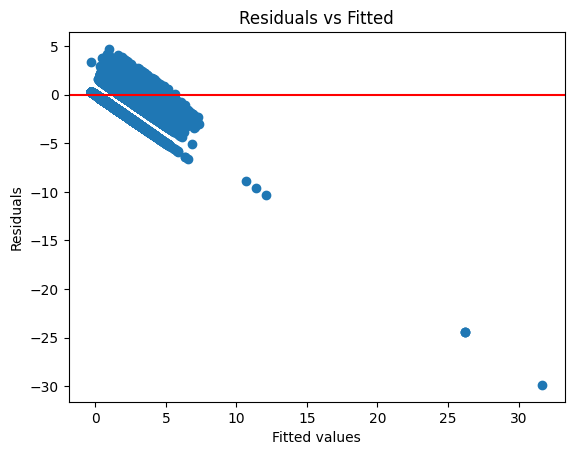

In [ ]:
# Residuals vs Fitted
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

 
**Problem:** If the residuals and fitted values show a linear relationship, this usually means that the linear regression model is not capturing the non-linear relationship between the independent and dependent variables. Linear models do not capture complex nonlinear patterns, so there may be some linear patterns remaining in the residuals. **If the residuals have a very strong linear relationship with the fitted values, this indicates that the linear model is not the most appropriate model.**

**Solution:** Use non-linear models

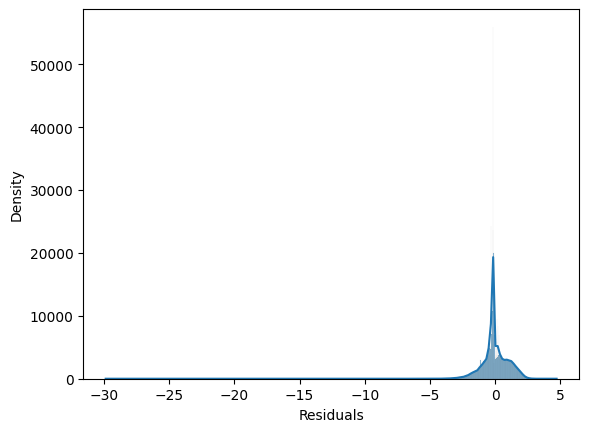

In [ ]:
# KDE plot of residuals
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()

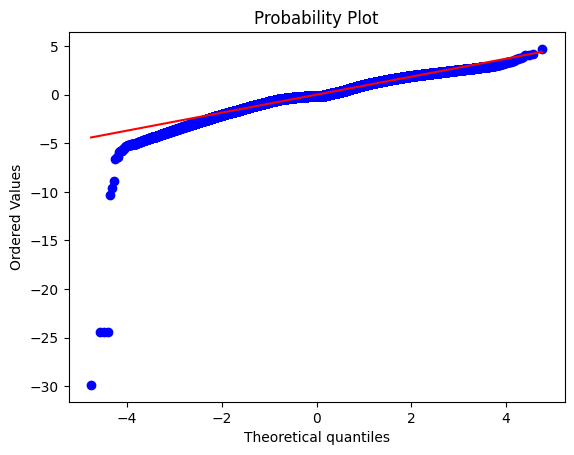

In [ ]:
# QQ plot of residuals
import scipy.stats as stats

stats.probplot(residuals, dist='norm', plot=plt)
plt.show()

 If the residuals exhibit **long tails** or **don't follow a normal distribution**, it could mean that:

- The model is not capturing the correct relationship between the independent and dependent variables.
- There are outliers or extreme values.
- There is heteroskedasticity or a non-linear relationship in the data.
- The model does not fit and more complex nonlinear models or data transformations need to be used to address these issues.

## XGBoost
### Using full features

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/BAP/waiting_times_processed.csv')

X = df.drop('WAIT_TIME_MAX_log', axis=1)
y = df['WAIT_TIME_MAX_log']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# XGBoost
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = xgb.score(X_test, y_test)

print(f'MSE: {mse}')
print(f'R2: {r2}')

MSE: 0.025612452969696383
R2: 0.9899637338747777


In [ ]:
y_test_real = np.expm1(y_test)
y_pred_real = np.expm1(y_pred)

mse_real = mean_squared_error(y_test_real, y_pred_real)
r2_real = r2_score(y_test_real, y_pred_real)

print(f'MSE real: {mse_real}')
print(f'R2 real: {r2_real}')

MSE real: 13.278789021162172
R2 real: 0.9700280226493945


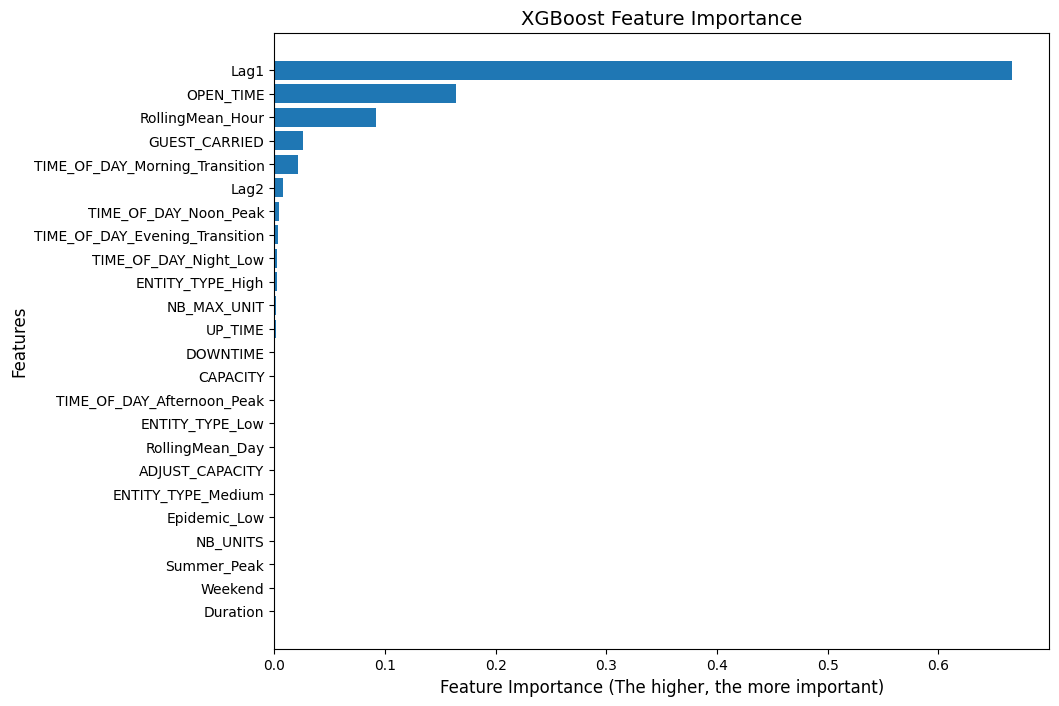

In [ ]:
# Feature importance
sorted_idx = np.argsort(xgb.feature_importances_)

plt.figure(figsize=(10, 8))
plt.barh(np.array(X_train.columns)[sorted_idx], xgb.feature_importances_[sorted_idx])
plt.xlabel('Feature Importance (The higher, the more important)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('XGBoost Feature Importance', fontsize=14)
plt.show()

In [ ]:
# hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

# define the hyperparameter grid
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'gamma': [0, 0.1, 0.2],
    'lambda': [1, 1.5, 2],
    'alpha': [0, 0.1, 0.5]
}

xgb_model = XGBRegressor()

# RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_model,
                                   param_distributions=param_dist,
                                   n_iter=100,
                                   scoring='neg_mean_squared_error',
                                   cv=3,
                                   verbose=1,
                                   random_state=42)
random_search.fit(X_train, y_train)

best_mse = abs(random_search.best_score_)
print("Best parameters: ", random_search.best_params_)
print("Best MSE: ", best_mse)
print("Best R2: ", random_search.best_estimator_.score(X_test, y_test))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters:  {'subsample': 0.9, 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.2, 'lambda': 2, 'gamma': 0, 'colsample_bytree': 0.7, 'alpha': 0.5}
Best MSE:  0.024297348340686854
Best R2:  0.9907328792593431


## LightGBM
### Using full features

In [ ]:
# LightGBM
import lightgbm as lgb

lgbm = lgb.LGBMRegressor(n_estimators=100, random_state=42)
lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = lgbm.score(X_test, y_test)

print(f'MSE: {mse}')
print(f'R2: {r2}')

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.289356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1466
[LightGBM] [Info] Number of data points in the train set: 2805743, number of used features: 23
[LightGBM] [Info] Start training from score 1.533671
MSE: 0.028414477879129974
R2: 0.988865757522655


In [ ]:
y_test_real = np.expm1(y_test)
y_pred_real = np.expm1(y_pred)

mse_real = mean_squared_error(y_test_real, y_pred_real)
r2_real = r2_score(y_test_real, y_pred_real)

print(f'MSE real: {mse_real}')
print(f'R2 real: {r2_real}')

MSE real: 14.731657000563668
R2 real: 0.9667487080897126


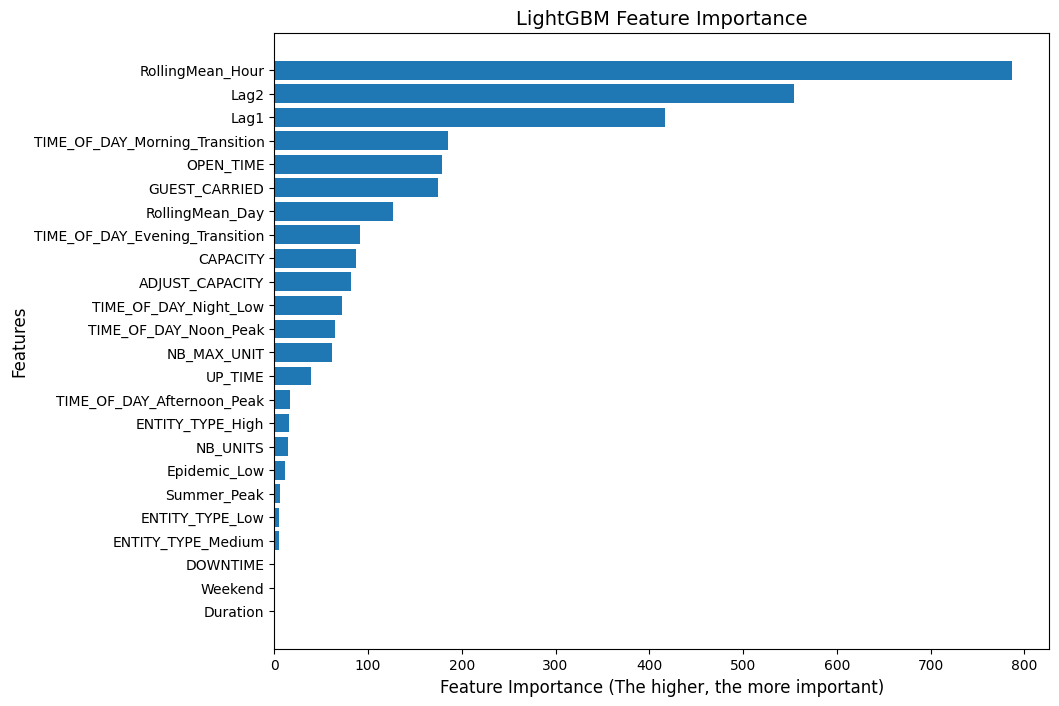

In [ ]:
# Feature importance
sorted_idx = np.argsort(lgbm.feature_importances_)
plt.figure(figsize=(10, 8))
plt.barh(np.array(X_train.columns)[sorted_idx], lgbm.feature_importances_[sorted_idx])
plt.xlabel('Feature Importance (The higher, the more important)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('LightGBM Feature Importance', fontsize=14)
plt.show()

In [ ]:
# hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb

# define the hyperparameter grid
param_dist = {
    'num_leaves': [20, 30, 40, 50],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_data_in_leaf': [20, 30, 40],
    'feature_fraction': [0.6, 0.8, 1.0],
    'bagging_fraction': [0.6, 0.8, 1.0],
    'bagging_freq': [0, 5, 10],
    'lambda_l1': [0, 0.1, 0.5],
    'lambda_l2': [0, 0.1, 0.5]
}

lgb_model = lgb.LGBMRegressor()

random_search = RandomizedSearchCV(estimator=lgb_model,
                                   param_distributions=param_dist,
                                   n_iter=100,
                                   scoring='neg_mean_squared_error',
                                   cv=3,
                                   verbose=1,
                                   random_state=42)
random_search.fit(X_train, y_train)

best_mse = abs(random_search.best_score_)
print("Best parameters : ", random_search.best_params_)
print("Best MSE: ", best_mse)
print("Best R2: ", random_search.best_estimator_.score(X_test, y_test))

流式输出内容被截断，只能显示最后 5000 行内容。
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

## Neural Network (Multilayer Perceptron, MLP)
### Using full features
 
Neural networks are sensitive to the scale of the features, so **normalise** the data to avoid slower convergence or poorer model performance.

In [ ]:
# MLP
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer

# define StandardScaler
scaler = StandardScaler()

# normalize the training set
X_train_scaled = scaler.fit_transform(X_train)

# normalize the test set
X_test_scaled = scaler.transform(X_test)

# define the MLP model
mlp = MLPRegressor(hidden_layer_sizes=(100, 100),
                   max_iter=1000,
                   random_state=42,
                   early_stopping=True,  
                   validation_fraction=0.3,  # using 30% of the training data as validation set
                   n_iter_no_change=10,  # stop training if validation score does not improve for 10 iterations
                   tol = 1e-3,  # tolerance for early stopping
                   verbose=True)  # print out messages

# cross-validation
# using negative mean squared error as scoring metric
scorer = make_scorer(mean_squared_error, greater_is_better=False)
cv_scores = cross_val_score(mlp, X_train_scaled, y_train, cv=5, scoring=scorer)

print(f'Cross-validated MSE (5-fold): {abs(cv_scores.mean())}')

Iteration 1, loss = 0.03156727
Validation score: 0.986339
Iteration 2, loss = 0.01570018
Validation score: 0.988686
Iteration 3, loss = 0.01376064
Validation score: 0.989880
Iteration 4, loss = 0.01298207
Validation score: 0.989976
Iteration 5, loss = 0.01253728
Validation score: 0.989965
Iteration 6, loss = 0.01222955
Validation score: 0.990034
Iteration 7, loss = 0.01198342
Validation score: 0.990650
Iteration 8, loss = 0.01181483
Validation score: 0.990103
Iteration 9, loss = 0.01169036
Validation score: 0.990383
Iteration 10, loss = 0.01157996
Validation score: 0.990830
Iteration 11, loss = 0.01145353
Validation score: 0.991090
Iteration 12, loss = 0.01137929
Validation score: 0.991139
Iteration 13, loss = 0.01127889
Validation score: 0.991116
Iteration 14, loss = 0.01122659
Validation score: 0.991123
Validation score did not improve more than tol=0.001000 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.03152928
Validation score: 0.986321
Iteration 2, loss = 0.01564979
V

In [ ]:
mlp.fit(X_train_scaled, y_train)

y_pred = mlp.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = mlp.score(X_test_scaled, y_test)

print(f'MSE on test set: {mse}')
print(f'R² on test set: {r2}')

Iteration 1, loss = 0.02818721
Validation score: 0.987995
Iteration 2, loss = 0.01486641
Validation score: 0.989189
Iteration 3, loss = 0.01333225
Validation score: 0.990094
Iteration 4, loss = 0.01273650
Validation score: 0.990279
Iteration 5, loss = 0.01232633
Validation score: 0.990374
Iteration 6, loss = 0.01205461
Validation score: 0.990831
Iteration 7, loss = 0.01184061
Validation score: 0.990889
Iteration 8, loss = 0.01171245
Validation score: 0.990921
Iteration 9, loss = 0.01157971
Validation score: 0.990823
Iteration 10, loss = 0.01152178
Validation score: 0.990901
Iteration 11, loss = 0.01139770
Validation score: 0.991238
Iteration 12, loss = 0.01132348
Validation score: 0.991184
Iteration 13, loss = 0.01127961
Validation score: 0.991012
Validation score did not improve more than tol=0.001000 for 10 consecutive epochs. Stopping.
MSE on test set: 0.022555824973272107
R² on test set: 0.991161476709258


This MSE value is very close to the cross-validated MSE, indicating that the model's performance on unseen data is close to its performance in cross-validation, suggesting that the model has good generalisation ability

In [ ]:
y_test_real = np.expm1(y_test)
y_pred_real = np.expm1(y_pred)

mse_real = mean_squared_error(y_test_real, y_pred_real)
r2_real = r2_score(y_test_real, y_pred_real)

print(f'MSE real: {mse_real}')
print(f'R2 real: {r2_real}')

MSE real: 14.214940418941314
R2 real: 0.9679150055326786


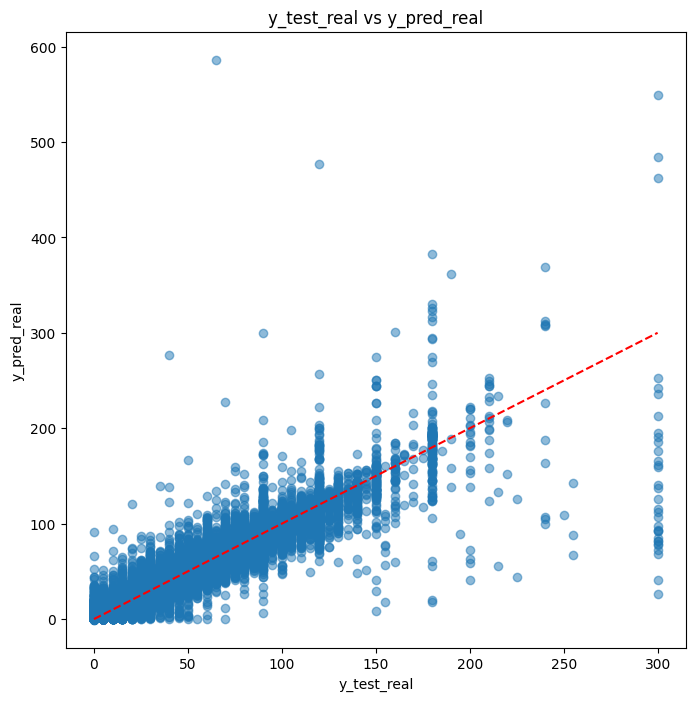

In [ ]:
# plot y_test_real vs y_pred_real
plt.figure(figsize=(8, 8))
plt.scatter(y_test_real, y_pred_real, alpha=0.5)
plt.plot([0, 300], [0, 300], color='red', linestyle='--')
plt.xlabel('y_test_real')
plt.ylabel('y_pred_real')
plt.title('y_test_real vs y_pred_real')
plt.show()

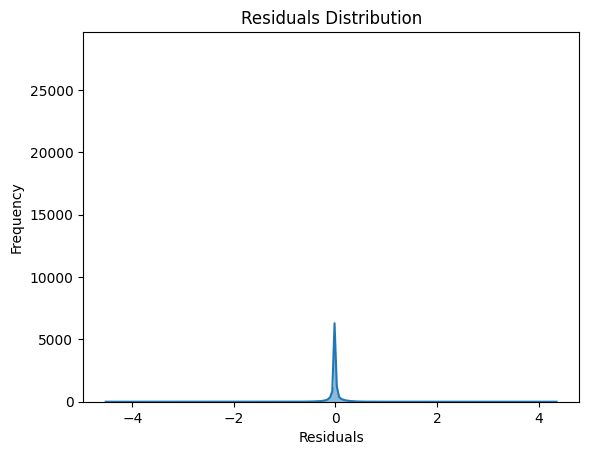

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

residuals = y_test - y_pred
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()